# Tujuan Proyek

Di sebuah startup yang menjual produk makanan saya menganalisis perilaku pengguna perusahaan tersebut, hal yang akan saya analisis adalah :
- mempelajari corong penjualannya : mengetahui tahapan pembelian dan  berapa pelanggan yang sampai pembelian makanan, dan melihat jumlah pelanggan yang berhenti di setiap tahap
- melakukan A/A testing dan A/B testing(pada kasus ini team design ingin mengubah font untuk aplikasi ini , tetapi ada ke khawatiran pelanggan malah tidak suka dengan design baru ini) dilakukan A/B testing untuk membagi kelompok dimana 1 kelompok menggunakan font baru dan yang 1 menggunakan font lama. Lalu juga melakukan A/A testing untuk melihat kelompok mana yang lebih memberikan keuntungan(dengan kondisi masih menggunakan font lama untuk uji coba A/A ini)

jadi disini ada 3 kelompok untuk pengujian, 2 kelompok bernama KELOMPOK A (dengan font lama) dan 1 kelompok bernama KELOMPOK B(dengan font baru).

In [1]:
#import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
from scipy import stats as st

In [2]:
#memuat data set
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/logs_exp_us.csv',sep="\t")

In [3]:
#melihat dataset apakah ada nilai hilang atau konversi tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
#menghitung duplikasi data
df.duplicated().sum()

413

In [5]:
#menghapus duplikasi data
df = df.drop_duplicates()

In [6]:
#konversi tipe data EventTimestamp jadi date time dan karena masih tanggal nya tipe timestamp maka harus dikonversi jadi 
#penanggalan biasa,dan menambah column berisi tanggal saja tanpa keterangan waktu
df['NewEventTimestamp'] = pd.to_datetime(df['EventTimestamp'],unit='s')
df['date'] = df['NewEventTimestamp'].dt.date
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId,NewEventTimestamp,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [8]:
#menghitung jumlah masing masing peristiwa yang terjadi
df['ExpId'].value_counts()

248    85582
246    80181
247    77950
Name: ExpId, dtype: int64

In [9]:
#jumlah peristiwa yang ada di data
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [10]:
#menghitung pengguna yang ada di dataset
df['DeviceIDHash'].nunique()

7551

In [11]:
#jumlah rata rata peristiwa per pengguna
df.groupby(['DeviceIDHash','EventName'])['DeviceIDHash'].count().mean()

12.06798712552612

<AxesSubplot:xlabel='date', ylabel='Count'>

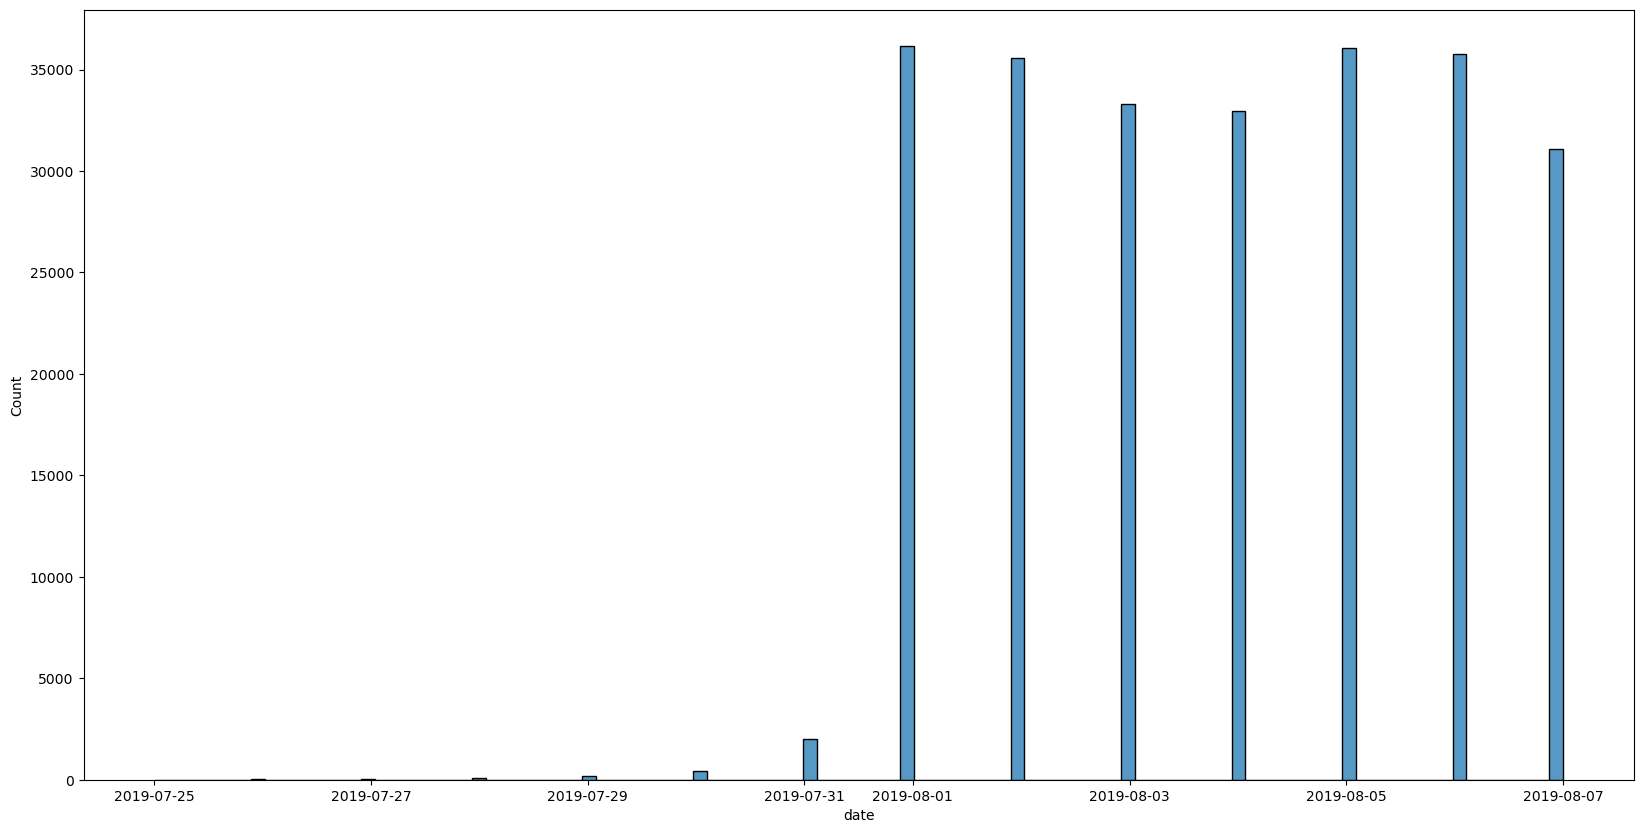

In [12]:
#Periode waktu yang dicakup oleh data
plt.figure(figsize=(20,10))
sns.histplot(data=df,x='date')

karena peristiwa paling banyak terjadi mulai periode 2019-08-01 saya hanya akan menggunakan data dari periode tersebut karena periode sebelumnya peristowa yang terjadi terlalu sedikit

In [13]:
df_filter = df[df['date']>'2019-07-31']

In [14]:
#mengecek berapa data yang hilang setelah melakukan filter data
len(df)-len(df_filter)

2826

In [15]:
#mengecek data yang sudah difilter harus memiliki dari ketiga pengguna
df_filter.groupby('ExpId').agg({'DeviceIDHash':'nunique'})

,DeviceIDHash
ExpId,
246,2484
247,2513
248,2537


### Lihat peristiwa apa saja yang ada dalam log dan berapa banyak frekuensi kemunculannya. Urutkan peristiwa tersebut berdasarkan frekuensi.

In [16]:
log_count = df_filter.groupby('EventName').agg({'DeviceIDHash':'count'}).reset_index().sort_values(by='DeviceIDHash',ascending=False)
log_count

,EventName,DeviceIDHash
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


### Temukan jumlah pengguna yang melakukan setiap tindakan. Urutkan peristiwa berdasarkan jumlah pengguna. Hitung proporsi pengguna yang melakukan tindakan setidaknya satu kali

In [17]:
user_do = df_filter.groupby('DeviceIDHash').agg({'EventName':'nunique'}).reset_index()
len(user_do[user_do['EventName']==5])

466

terdapat 375 user yang melakukan semua event dari awal hingga akhir, disini ada 5 event jadi ada 375 pengunjung yang melakukan ke 5 event ini

#### Gunakan corong peristiwa untuk menemukan persentase pengguna yang terus berlanjut dari satu tahap ke tahap berikutnya. (Misalnya, untuk urutan peristiwa A → B → C, hitung rasio pengguna pada tahap B terhadap jumlah pengguna pada tahap A, serta rasio pengguna pada tahap C terhadap jumlah pengguna pada tahap B).

In [18]:
event_count = df_filter.groupby('EventName')['DeviceIDHash'].nunique().reset_index().sort_values(by='DeviceIDHash',ascending=False)
event_count['d2'] = event_count['DeviceIDHash'].shift(-1)
event_count['ratio'] = ((event_count['d2']/event_count['DeviceIDHash'])*100).shift(1).round()
event_count

,EventName,DeviceIDHash,d2,ratio
1,MainScreenAppear,7419,4593.0,NaN
2,OffersScreenAppear,4593,3734.0,62.0
0,CartScreenAppear,3734,3539.0,81.0
3,PaymentScreenSuccessful,3539,840.0,95.0
4,Tutorial,840,NaN,24.0


pada bagian ini manganalisis jumlah rasio setiap proses dari satu ke selanjutnya terlihat dari awal proses rasionya semakin menurun karena tidak semua customer melakukan proses pemesanan makanan di aplikasi sampai selesai

# mempelajari hasil eksperimen

In [19]:
#menghitung jumla anggota masing masing kelompok uji
total_user = df_filter.groupby('ExpId').agg({'DeviceIDHash':'nunique'})
total_user.loc[246]

DeviceIDHash    2484
Name: 246, dtype: int64

#### Kita memiliki dua kelompok kontrol dalam A/A testing, di mana kita memeriksa mekanisme dan perhitungan kita. Perhatikan apakah terdapat perbedaan yang signifikan secara statistik antara sampel 246 dan 247.

In [20]:
user_per_event = df_filter.pivot_table(index='EventName',columns='ExpId',values='DeviceIDHash',aggfunc='nunique')
user_per_event

ExpId,246,247,248
EventName,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


tidak ada perbedaan signifikan setiap event untuk kelompok uji

In [21]:
def hipotesting(convert1,convert2,total1,total2,alpha = 0.05):
    #succes rate kelompok 246
    p1 = convert1/total1
    #succes rate kelompok 247
    p2 = convert2/total2
    #combine succes rate
    combine=(convert1+convert2)/(total1+total2)

    difference = p1-p2

    #calculating statistic standard deviasi distribusi normal
    z_value = difference/mt.sqrt(combine*(1-combine) * (1/total1 + 1/total2))

    #setting standart normal distribusion
    distr = st.norm(0,1)

    pvalue = (1-distr.cdf(abs(z_value))) *2
    
    print(pvalue)
    
    if (pvalue < alpha) :
        print("menolak H0 : ada perbedaan signifikan antara 2 kelompok")
    else:
        print("gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok")


fungsi yang digunakan untuk melakukan uji statistik apakah disetiap proses event untuk setiap kelompok yang dibandingkan ada perbedaan signifikan atau tidak

In [22]:
#menguji untuk setiap event apakah ada perbedaan atau tidak untuk setiap kelompok
hipotesting(user_per_event.loc['MainScreenAppear',246],
            user_per_event.loc['MainScreenAppear',247],
            total_user.loc[246],
            total_user.loc[247]
           )

[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok


#### Pilih peristiwa yang paling populer. Pada setiap kelompok kontrol, temukan jumlah pengguna yang melakukan tindakan tersebut. Temukan persentasenya. Periksa apakah perbedaan antar kelompok signifikan secara statistik dengan alpha 0.05

In [24]:
#menguji A/A testing untuk setiap peristiwa di kelompok 246 247
for EventName in user_per_event.index:
    popular_event(user_per_event,total_user,246,247,EventName)
    
    print()

DeviceIDHash    0.509662
Name: 246, dtype: float64 with CartScreenAppearin group246
DeviceIDHash    0.492638
Name: 247, dtype: float64 with CartScreenAppearin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.986312
Name: 246, dtype: float64 with MainScreenAppearin group246
DeviceIDHash    0.985277
Name: 247, dtype: float64 with MainScreenAppearin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.620773
Name: 246, dtype: float64 with OffersScreenAppearin group246
DeviceIDHash    0.604855
Name: 247, dtype: float64 with OffersScreenAppearin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.483092
Name: 246, dtype: float64 with PaymentScreenSuccessfulin group246
DeviceIDHash    0.460804
Name: 247, dtype: float64 with PaymentScreenSuccessfulin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan a

In [25]:
#menguji A/B testing untuk setiap peristiwa di kelompok 246 248
for EventName in user_per_event.index:
    popular_event(user_per_event,total_user,246,248,EventName)
    
    print()

DeviceIDHash    0.509662
Name: 246, dtype: float64 with CartScreenAppearin group246
DeviceIDHash    0.484825
Name: 248, dtype: float64 with CartScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.986312
Name: 246, dtype: float64 with MainScreenAppearin group246
DeviceIDHash    0.982657
Name: 248, dtype: float64 with MainScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.620773
Name: 246, dtype: float64 with OffersScreenAppearin group246
DeviceIDHash    0.603469
Name: 248, dtype: float64 with OffersScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.483092
Name: 246, dtype: float64 with PaymentScreenSuccessfulin group246
DeviceIDHash    0.46551
Name: 248, dtype: float64 with PaymentScreenSuccessfulin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan an

In [26]:
#menguji A/B testing untuk setiap peristiwa di kelompok 247 248
for EventName in user_per_event.index:
    popular_event(user_per_event,total_user,247,248,EventName)
    
    print()

DeviceIDHash    0.492638
Name: 247, dtype: float64 with CartScreenAppearin group247
DeviceIDHash    0.484825
Name: 248, dtype: float64 with CartScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.985277
Name: 247, dtype: float64 with MainScreenAppearin group247
DeviceIDHash    0.982657
Name: 248, dtype: float64 with MainScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.604855
Name: 247, dtype: float64 with OffersScreenAppearin group247
DeviceIDHash    0.603469
Name: 248, dtype: float64 with OffersScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.460804
Name: 247, dtype: float64 with PaymentScreenSuccessfulin group247
DeviceIDHash    0.46551
Name: 248, dtype: float64 with PaymentScreenSuccessfulin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan an

#### Pilih peristiwa yang paling populer. Pada setiap kelompok kontrol, temukan jumlah pengguna yang melakukan tindakan tersebut. Temukan persentasenya. Periksa apakah perbedaan antar kelompok signifikan secara statistik dengan alpha 0.01

In [27]:
def hipotesting2(convert1,convert2,total1,total2,alpha = 0.01):
    #succes rate kelompok 246
    p1 = convert1/total1
    #succes rate kelompok 247
    p2 = convert2/total2
    #combine succes rate
    combine=(convert1+convert2)/(total1+total2)

    difference = p1-p2

    #calculating statistic standard deviasi distribusi normal
    z_value = difference/mt.sqrt(combine*(1-combine) * (1/total1 + 1/total2))

    #setting standart normal distribusion
    distr = st.norm(0,1)

    pvalue = (1-distr.cdf(abs(z_value))) *2
    
    print(pvalue)
    
    if (pvalue < alpha) :
        print("menolak H0 : ada perbedaan signifikan antara 2 kelompok")
    else:
        print("gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok")


In [29]:
def popular_event2(user_per_event,total_user,exp1,exp2,EventName):
    grup1 = user_per_event.loc[EventName,exp1]/total_user.loc[exp1]
    grup2 = user_per_event.loc[EventName,exp2]/total_user.loc[exp2]
    print(f'{grup1} with {EventName}in group{exp1}')
    print(f'{grup2} with {EventName}in group{exp2}')
    hipotesting2(user_per_event.loc['MainScreenAppear',246],
            user_per_event.loc['MainScreenAppear',247],
            total_user.loc[246],
            total_user.loc[247]
               )

In [30]:
#menguji A/A testing untuk setiap peristiwa di kelompok 246 247
for EventName in user_per_event.index:
    popular_event2(user_per_event,total_user,246,247,EventName)
    
    print()

DeviceIDHash    0.509662
Name: 246, dtype: float64 with CartScreenAppearin group246
DeviceIDHash    0.492638
Name: 247, dtype: float64 with CartScreenAppearin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.986312
Name: 246, dtype: float64 with MainScreenAppearin group246
DeviceIDHash    0.985277
Name: 247, dtype: float64 with MainScreenAppearin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.620773
Name: 246, dtype: float64 with OffersScreenAppearin group246
DeviceIDHash    0.604855
Name: 247, dtype: float64 with OffersScreenAppearin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.483092
Name: 246, dtype: float64 with PaymentScreenSuccessfulin group246
DeviceIDHash    0.460804
Name: 247, dtype: float64 with PaymentScreenSuccessfulin group247
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan a

In [33]:
#menguji A/B testing untuk setiap peristiwa di kelompok 246 248
for EventName in user_per_event.index:
    popular_event2(user_per_event,total_user,247,248,EventName)
    
    print()

DeviceIDHash    0.492638
Name: 247, dtype: float64 with CartScreenAppearin group247
DeviceIDHash    0.484825
Name: 248, dtype: float64 with CartScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.985277
Name: 247, dtype: float64 with MainScreenAppearin group247
DeviceIDHash    0.982657
Name: 248, dtype: float64 with MainScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.604855
Name: 247, dtype: float64 with OffersScreenAppearin group247
DeviceIDHash    0.603469
Name: 248, dtype: float64 with OffersScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.460804
Name: 247, dtype: float64 with PaymentScreenSuccessfulin group247
DeviceIDHash    0.46551
Name: 248, dtype: float64 with PaymentScreenSuccessfulin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan an

In [32]:
#menguji A/B testing untuk setiap peristiwa di kelompok 247 248
for EventName in user_per_event.index:
    popular_event2(user_per_event,total_user,247,248,EventName)
    
    print()

DeviceIDHash    0.492638
Name: 247, dtype: float64 with CartScreenAppearin group247
DeviceIDHash    0.484825
Name: 248, dtype: float64 with CartScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.985277
Name: 247, dtype: float64 with MainScreenAppearin group247
DeviceIDHash    0.982657
Name: 248, dtype: float64 with MainScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.604855
Name: 247, dtype: float64 with OffersScreenAppearin group247
DeviceIDHash    0.603469
Name: 248, dtype: float64 with OffersScreenAppearin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan antara 2 kelompok

DeviceIDHash    0.460804
Name: 247, dtype: float64 with PaymentScreenSuccessfulin group247
DeviceIDHash    0.46551
Name: 248, dtype: float64 with PaymentScreenSuccessfulin group248
[0.75705972]
gagal menolak H0 : tidak ada perbedaan signifikan an

# Kesimpulan 

kesimpulan dari testing ini adalah untuk setiap event dalam log data baik kelompok uji 248 dan kelompok kontrol 246 dan 247 tidak ada perbedaan signifikan untuk setiap peristiwa, jadi artinya penyebaran user untuk setiap kelompok tidak bebeda jauh dan untuk setip user per-event jumlahnya juga tidak ada perbedaan signifikan, artinya penyebaran usernya merata baik untuk setiap kelompok uji maupun penyebaran user per-event pada setiap kelompok uji, hasilnya sudah diuji menggunakan distribusi kumulatif walaupun kita menggunakan data yang dari periode 01-08-2019 keatas (tidak semua data) saya rasa hasilnya akan sama saja jika kita menggunakan seluruh data dari awal periode, karena diawal periode datanya tidak terlalu banyak bedanya juga tidak terlalu banyak antara jumlah data dari periode 01-08-2019 yang jumlahnya 240ribuan dibanding dengan seluruh data dari awal periode yang jumlahnya 243ribuan dan bisa dikatakan perilaku pengguna dari masing masing kelompok 246,247,248 perilakunya hampir sama dengan melihat dari corong peristiwa juga bisa dikatakan perilakuknya sama yaitu banyak pengguna pada event MainScreenAppear lalu seiring berjalannya event ke OffersScreenAppear usernya turun artinya lebih sedikit yang menjalankan event ini dan selanjutnya pun sama untuk event CartScreenAppear	,PaymentScreenSuccessful, Tutorial	yang jumlahnya semakin mengerucut/mengecil seperti corong, ini berlaku untuk semua kelompok baik 246,247,248